# Data Cleaning

This notebook acquires the enrolments and the course descriptions and formats the different fields. This includes cleaning the data and standardizing it so that it may be exploitable for the construction of the different graphs. 


In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import string
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
import pickle
import os

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package wordnet to /Users/laila/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/laila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/laila/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 0. Formatting and Loading the Data

The data had issues in encoding and could not be read properly on different operating systems. That is why we needed to reformat it. The results are saved with the extension _new. 

In [2]:
#replace unnecessary double quotes in files
for file in ["PV_Course_Enrolments", "PV_Course_Descriptions"]:
    with open('../data/{}.csv'.format(file),'r',encoding="utf8") as courses_old:
        with open('../data/{}_new.csv'.format(file),'w',encoding="utf8") as courses_new:
            lines=courses_old.readlines()
            for line in lines:
                if(len(line)>2):
                    line=re.sub(r'(?<!,)"(?!,)',"'",line)
                courses_new.write(line)

# 1. Course Descriptions

This portion handles the course descriptions as provided on the EPFL website. It contains multiple attributes characterizing the different courses. The main issue with this dataset is that the data is not standard and significant cleaning is required, especially for textual inputs.

## 1.1. Keeping only essential data

* CourseCode
* CourseTitle (FR-EN)
* proffessorSCIPERs
* StudyPlans(FR-EN)
* KeyWords(FR-EN) (as well as Contents, Summary and ImportantConcepts)
* (Mandatory-Indicative)Prerequirements(FR-EN)



In [3]:
courses=pd.read_csv("../data/PV_Course_Descriptions_new.csv",quotechar='"', iterator=False, encoding="utf8", 
                    error_bad_lines=False)

courses.columns

Index(['AcademicYear', 'CourseCode', 'CourseTitleFR', 'CourseTitleEN',
       'ProfessorSCIPERs', 'AssistantSCIPERs', 'StudyPlansFR', 'StudyPlansEN',
       'Summary_FR', 'Summary_EN', 'KeyWords_FR', 'KeyWords_EN', 'Content_FR',
       'Content_EN', 'ImportantConcepts_FR', 'ImportantConcepts_EN',
       'MandatoryPrerequirements_FR', 'MandatoryPrerequirements_EN',
       'IndicativePrerequirements_FR', 'IndicativePrerequirements_EN',
       'PreparesFor_FR', 'PreparesFor_EN', 'Handouts_FR', 'Handouts_EN',
       'Bibliography_FR', 'Bibliography_EN', 'TeachingMethod_FR',
       'TeachingMethod_EN', 'EvaluationMethod_FR', 'EvaluationMethod_EN',
       'ExpectedWork_FR', 'ExpectedWork_EN', 'Other_FR', 'Other_EN',
       'ProjectManagement', 'WorkInSociety', 'PersonalEffectiveness',
       'TrainingAchievements', 'WorkInGroupsAndOrgs',
       'CommunicateInformation'],
      dtype='object')

In [4]:
courses.drop( ['ExpectedWork_FR', 'ExpectedWork_EN', 
               'Other_FR', 'Other_EN',
               'ProjectManagement', 'WorkInSociety', 'PersonalEffectiveness',
               'TrainingAchievements', 'WorkInGroupsAndOrgs',
               'CommunicateInformation','Handouts_FR', 'Handouts_EN',
               'Bibliography_FR', 'Bibliography_EN','TeachingMethod_FR', 'TeachingMethod_EN', 
               'EvaluationMethod_FR','EvaluationMethod_EN' ], axis = 1, inplace = True)

print(courses.columns)

courses.set_index("CourseCode", inplace = True)

Index(['AcademicYear', 'CourseCode', 'CourseTitleFR', 'CourseTitleEN',
       'ProfessorSCIPERs', 'AssistantSCIPERs', 'StudyPlansFR', 'StudyPlansEN',
       'Summary_FR', 'Summary_EN', 'KeyWords_FR', 'KeyWords_EN', 'Content_FR',
       'Content_EN', 'ImportantConcepts_FR', 'ImportantConcepts_EN',
       'MandatoryPrerequirements_FR', 'MandatoryPrerequirements_EN',
       'IndicativePrerequirements_FR', 'IndicativePrerequirements_EN',
       'PreparesFor_FR', 'PreparesFor_EN'],
      dtype='object')


## 1.2. Formatting the Different Fields
Due to issues in encoding, low level cleaning was required before the data could be readable. 

In [5]:
# suppress incorect <p> html balise
def findCorrectBalise(string):
    if(type(string)==type('')):
        string=re.sub(r'!-*\[endif\] ?--&gt;(?!&lt;//?p)', '!--[endif] --&gt;&lt;/p&gt;\r\n&lt;p&gt;',string)
        begIndex=list(re.finditer('&lt;p&gt;',string))
        endIndex=list(re.finditer('&lt;/p&gt;',string))
        for openP,closeP in zip(begIndex,endIndex):
            #print(openP.start(),closeP.end())
            if 'mso' not in string[openP.start():closeP.end()] and 'padding-top' not in string[openP.start():closeP.end()] and '&gt;&amp;#160;&lt' not in string[openP.start():closeP.end()]:
                return string[openP.start():closeP.end()]
    return string

In [6]:
# replace html code with unicode character
def htmlToStr(match):
    match =match.group()
    code=int(re.findall(r'(?<=\&amp;#)\d+(?=;)',match)[0])
    return chr(code)

mapToChange={'<squote/>':"'",'<comma/>':",",'&lt;p&gt;':'','&apos;':"'",' &amp; ':' et ','&lt;-&gt;':'-',
             '&lt;/p&gt;':'','&lt;br /&gt;':'\r\n','&lt;ul&gt;':'','&lt;/li&gt;':'','&lt;/ul&gt;':'','&lt;li&gt;':'',
            '&lt;ol&gt;':'','&lt;/ol&gt;':'','&lt;i&gt;':'','&lt;/i&gt;':'','&quot;':"'",'&lt;/em&gt;':'','&lt;em&gt;':'',
            '&lt;b&gt;':'','&lt;/b&gt;':'','&lt;strong&gt;':'','&lt;/strong&gt;':'','&amp;amp;':'&',
            '&lt;a.*&gt;':'','&lt;/a&gt;':'','&lt;!-+.*-+&gt;':'','&lt;span.+&gt;':'','&amp;lt;':'<','&amp;gt;':'>'}
for col in courses.columns:
    courses[col]=courses[col].apply(findCorrectBalise)
    for pattern in mapToChange.keys():
        courses[col]=courses[col].str.replace(pattern, mapToChange[pattern],case=True)
    courses[col]=courses[col].str.replace(r'&amp;#[0-9]{3,5};',htmlToStr,case=True)

In [7]:
print("There are {} courses".format(len(courses)))
courses.head()

There are 1348 courses


,AcademicYear,CourseTitleFR,CourseTitleEN,ProfessorSCIPERs,AssistantSCIPERs,StudyPlansFR,StudyPlansEN,Summary_FR,Summary_EN,KeyWords_FR,...,Content_FR,Content_EN,ImportantConcepts_FR,ImportantConcepts_EN,MandatoryPrerequirements_FR,MandatoryPrerequirements_EN,IndicativePrerequirements_FR,IndicativePrerequirements_EN,PreparesFor_FR,PreparesFor_EN
CourseCode,,,,,,,,,,,,,,,,,,,,,
AR-101,2016-2017,Théorie et critique du projet BA1,Studio BA1,173997,NaN,AR - Bachelor 2016,NaN,Le semestre se concentre sur l'acquisition des...,The semester focuses on the tools and processe...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR-102,2016-2017,Théorie et critique du projet BA2,Studio BA2,173997,NaN,AR - Bachelor 2016,NaN,Le 2ème semestre propose une condition de labo...,Semester 2 provides a laboratory condition in ...,NaN,...,NaN,NaN,NaN,NaN,NaN,AR-101 Théorie et critique du projet BA1.,NaN,NaN,NaN,NaN
AR-111,2016-2017,Figuration graphique I,Graphic figuration I,106453;180534,NaN,AR - Bachelor 2016,NaN,Initiation au dessin d'architecture à travers ...,Initiation to the practice of architectural dr...,géométrie _ procédure graphique_ expression gr...,...,L'abécédaire de la représentation.,The ABC of representation.,NaN,NaN,NaN,NaN,NaN,NaN,Figuration graphique II,Art of drawing II
AR-112,2016-2017,Figuration graphique II,Graphic figuration II,180534;106453,NaN,AR - Bachelor 2016,NaN,A partir des acquisitions de AR-111 Figuration...,"After AR-111 Graphic figuration I, applying th...",lecture graphique _ maquette graphique _ dessi...,...,\nLecture et interprétation graphique de docum...,\nReading and graphic interpreting of architec...,NaN,NaN,AR-111 Figuration graphique I.,See AR-111 Graphic figuration I.,NaN,NaN,NaN,NaN
AR-121,2016-2017,Théorie de l'architecture I,Theory of architecture I,105747,NaN,AR - Bachelor 2016,NaN,Le cours vise à offrir à l'étudiant une vision...,Provide the student with a broad vision of the...,"Eléments, architecture, espace, fonction, théo...",...,"Au premier semestre, le cours dispense les not...",The objective of the course is an introduction...,"Modernité architecturale, plasticité, structur...",NaN,-,NaN,-,NaN,NaN,NaN


## 1.3. Removing Irrelevant Courses For The Application
We are interested in recommending courses which are related, SHS courses are not linked to other courses. That is why these are not considered. 

**Removing Social Science Courses**

In [8]:
courses = courses[courses.index.str.contains("HUM") == False]    

#ARcourse = courses.index[courses.StudyPlansFR.str.contains('AR')].tolist()
#SIEcourse = courses.index[courses.StudyPlansFR.str.contains('ENV')].tolist()
#GCcourse = courses.index[courses.StudyPlansFR.str.contains('^ ?GC| ?; ?GC')].tolist()
#ARcourse=list(set(ARcourse)-set(SIEcourse)-set(GCcourse))

#courses = courses[~courses.index.isin(ARcourse)]

#courses = courses[~courses.index.str.contains("AR|HUM|BIO|CH|ChE|CIVIL|ENV|ETH|HEP|MATH|PHYS")]
print("There are {} courses".format(len(courses)))

courses.head()

There are 1192 courses


,AcademicYear,CourseTitleFR,CourseTitleEN,ProfessorSCIPERs,AssistantSCIPERs,StudyPlansFR,StudyPlansEN,Summary_FR,Summary_EN,KeyWords_FR,...,Content_FR,Content_EN,ImportantConcepts_FR,ImportantConcepts_EN,MandatoryPrerequirements_FR,MandatoryPrerequirements_EN,IndicativePrerequirements_FR,IndicativePrerequirements_EN,PreparesFor_FR,PreparesFor_EN
CourseCode,,,,,,,,,,,,,,,,,,,,,
AR-101,2016-2017,Théorie et critique du projet BA1,Studio BA1,173997,NaN,AR - Bachelor 2016,NaN,Le semestre se concentre sur l'acquisition des...,The semester focuses on the tools and processe...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR-102,2016-2017,Théorie et critique du projet BA2,Studio BA2,173997,NaN,AR - Bachelor 2016,NaN,Le 2ème semestre propose une condition de labo...,Semester 2 provides a laboratory condition in ...,NaN,...,NaN,NaN,NaN,NaN,NaN,AR-101 Théorie et critique du projet BA1.,NaN,NaN,NaN,NaN
AR-111,2016-2017,Figuration graphique I,Graphic figuration I,106453;180534,NaN,AR - Bachelor 2016,NaN,Initiation au dessin d'architecture à travers ...,Initiation to the practice of architectural dr...,géométrie _ procédure graphique_ expression gr...,...,L'abécédaire de la représentation.,The ABC of representation.,NaN,NaN,NaN,NaN,NaN,NaN,Figuration graphique II,Art of drawing II
AR-112,2016-2017,Figuration graphique II,Graphic figuration II,180534;106453,NaN,AR - Bachelor 2016,NaN,A partir des acquisitions de AR-111 Figuration...,"After AR-111 Graphic figuration I, applying th...",lecture graphique _ maquette graphique _ dessi...,...,\nLecture et interprétation graphique de docum...,\nReading and graphic interpreting of architec...,NaN,NaN,AR-111 Figuration graphique I.,See AR-111 Graphic figuration I.,NaN,NaN,NaN,NaN
AR-121,2016-2017,Théorie de l'architecture I,Theory of architecture I,105747,NaN,AR - Bachelor 2016,NaN,Le cours vise à offrir à l'étudiant une vision...,Provide the student with a broad vision of the...,"Eléments, architecture, espace, fonction, théo...",...,"Au premier semestre, le cours dispense les not...",The objective of the course is an introduction...,"Modernité architecturale, plasticité, structur...",NaN,-,NaN,-,NaN,NaN,NaN


**Removing First Year Courses **

In [9]:
for idx in courses.index:
    if(idx=='BIO-105' or idx=='PHYS-114'):
        continue
    m=re.search(r'\d', idx)
    if idx[m.start()] == "1":
        courses.drop(idx, inplace = True)
        
print("There are {} courses".format(len(courses)))

There are 1044 courses


In [10]:
print(len(courses))
for col in courses.columns.tolist():
    print(col, len(courses[col].unique()))

1044
AcademicYear 1
CourseTitleFR 1026
CourseTitleEN 458
ProfessorSCIPERs 696
AssistantSCIPERs 436
StudyPlansFR 549
StudyPlansEN 8
Summary_FR 981
Summary_EN 983
KeyWords_FR 535
KeyWords_EN 584
Content_FR 892
Content_EN 941
ImportantConcepts_FR 275
ImportantConcepts_EN 317
MandatoryPrerequirements_FR 310
MandatoryPrerequirements_EN 379
IndicativePrerequirements_FR 520
IndicativePrerequirements_EN 467
PreparesFor_FR 312
PreparesFor_EN 223


## 1.2 Simplifying Study Plans

In [11]:
import re

def remove_numbers(string):
    if string is not np.nan:
        return re.sub(r'[0-9]+', '', string)
    else :
        return string

def remove_all_after_word(word, string, included = False):
    if string:
        string = re.sub(r'[0-9]+', '', string)
        r = re.compile('(.*?)(?:{}.*?$|\Z)'.format(word),
                       re.MULTILINE|re.DOTALL)
        if word in string:
            if included :
                return ''.join(r.findall(string))
            else :
                return ''.join(r.findall(string))+word
        else:
            return string
    return string

In [12]:
courses = courses.join(courses.StudyPlansFR.str.split(";",expand=True))
print(len(courses["StudyPlansFR"].unique()))


549


Looking at columns to see how many came from the split

In [13]:
courses.columns

Index([                'AcademicYear',                'CourseTitleFR',
                      'CourseTitleEN',             'ProfessorSCIPERs',
                   'AssistantSCIPERs',                 'StudyPlansFR',
                       'StudyPlansEN',                   'Summary_FR',
                         'Summary_EN',                  'KeyWords_FR',
                        'KeyWords_EN',                   'Content_FR',
                         'Content_EN',         'ImportantConcepts_FR',
               'ImportantConcepts_EN',  'MandatoryPrerequirements_FR',
        'MandatoryPrerequirements_EN', 'IndicativePrerequirements_FR',
       'IndicativePrerequirements_EN',               'PreparesFor_FR',
                     'PreparesFor_EN',                              0,
                                    1,                              2,
                                    3,                              4,
                                    5,                              6,
      

In [14]:
for study_plan in range(16):
    for word in ["HES", "Bachelor","Echange", "Master"]:
        courses[study_plan]= courses[study_plan].apply(lambda x: remove_all_after_word(word, x, included = True))
    for word in ["UNIL", "STAS", "CGC", "AR", "GC", "GM", "IN", "IF", "MA", "SV",\
                "SIE", "SHS", "PH", "HD", "MES", "MTEE", "MT ", "SC", "SIE", "MX"]:
        courses[study_plan]= courses[study_plan].apply(lambda x: remove_all_after_word(word, x, included = False))
    
    courses[study_plan]= courses[study_plan].str.replace(' - ', ' ').replace('- ', '').replace(' -', '').replace('-', '')
    
study_plans = []
for i in range(16):
    study_plans += list(courses[i].unique())

study_plans = sorted(list(set(list(filter(None,study_plans)))))
print(len(study_plans))
study_plans


37


['AR',
 'Auditeurs en ligne -',
 'CGC',
 'Computer engineering minor -',
 'EL ',
 'EL MNIS ',
 'GC',
 'GM',
 'HD',
 'Hors plans ',
 'IF',
 'IN',
 'Information security minor -',
 'MA',
 'MES',
 'MT ',
 'MTEE',
 'MX',
 'Mineur : Biocomputing -',
 'Mineur : Biotechnologie -',
 'Mineur : Design intégré, architecture et durabilité -',
 'Mineur : Développement territorial et urbanisme -',
 'Mineur : Informatique -',
 'Mineur : Management de la technologie et entrepreneuriat -',
 'Mineur : Neuroprosthétiques -',
 'Mineur : Neurosciences computationnelles -',
 'Mineur : Systems Engineering -',
 'Mineur : Systèmes de communication -',
 'Mineur : Technologies biomédicales -',
 'Mineur : Technologies spatiales -',
 'Mineur : Énergie -',
 'Mineur STAS',
 'PH',
 'SC',
 'SIE',
 'SV',
 'UNIL']

In [15]:
courses["StudyPlansEN"]= courses["StudyPlansEN"].apply(lambda x:remove_numbers(x))                                                                         
cols = [i for i in range(16)]+["StudyPlansEN"]
courses["StudyPlans"] = courses[cols].apply(lambda x: '; '.join(sorted(list(set(x.dropna().astype(str))))),axis=1)
cols +=["StudyPlansFR"]
courses.drop(cols, axis = 1, inplace = True)

In [16]:
courses["StudyPlans"].unique()

array(['AR', 'GC', 'AR; HD',
       'AR; Mineur : Design intégré, architecture et durabilité -',
       'AR; Mineur : Développement territorial et urbanisme -',
       'AR; Mineur : Design intégré, architecture et durabilité -; Mineur : Développement territorial et urbanisme -',
       'HD',
       'AR; MES; Mineur : Design intégré, architecture et durabilité -; Mineur : Développement territorial et urbanisme -',
       'AR; HD; Mineur : Développement territorial et urbanisme -',
       'AR; GC', 'AR; Hors plans ',
       'IN; Mineur : Neuroprosthétiques -; Mineur : Technologies biomédicales -; SC',
       'CGC', 'SV', 'MA; Mineur : Biocomputing -; SV',
       'Mineur : Systems Engineering -; SV',
       'Mineur : Technologies biomédicales -; SV', 'MT ; SV',
       'EDCE -;EDNE -; SV',
       'EDNE -; EL ; IN; MA; Mineur : Biocomputing -; Mineur : Neuroprosthétiques -; Mineur : Neurosciences computationnelles -; Mineur : Technologies biomédicales -; SC; SV',
       'EDNE -; Mineur : Ne

High because all the possible combinations are taken into account and were not sorted.

In [17]:
courses.columns

Index(['AcademicYear', 'CourseTitleFR', 'CourseTitleEN', 'ProfessorSCIPERs',
       'AssistantSCIPERs', 'Summary_FR', 'Summary_EN', 'KeyWords_FR',
       'KeyWords_EN', 'Content_FR', 'Content_EN', 'ImportantConcepts_FR',
       'ImportantConcepts_EN', 'MandatoryPrerequirements_FR',
       'MandatoryPrerequirements_EN', 'IndicativePrerequirements_FR',
       'IndicativePrerequirements_EN', 'PreparesFor_FR', 'PreparesFor_EN',
       'StudyPlans'],
      dtype='object')

In [18]:
courses.head()

,AcademicYear,CourseTitleFR,CourseTitleEN,ProfessorSCIPERs,AssistantSCIPERs,Summary_FR,Summary_EN,KeyWords_FR,KeyWords_EN,Content_FR,Content_EN,ImportantConcepts_FR,ImportantConcepts_EN,MandatoryPrerequirements_FR,MandatoryPrerequirements_EN,IndicativePrerequirements_FR,IndicativePrerequirements_EN,PreparesFor_FR,PreparesFor_EN,StudyPlans
CourseCode,,,,,,,,,,,,,,,,,,,,
AR-201(a),2016-2017,Théorie et critique du projet BA3 (Bakker & Bl...,Studio BA3 (Bakker & Blanc A.),115080;143954,NaN,MANSLAB se concentre sur la question de l`asse...,MANSLAB will concentrate on the question of a ...,"Lyon, Rhône, îles, Cimetieres, Rives, Habitati...",NaN,AU-DELÀ\r\n\r\nLe MANSLAB façonne des assembla...,The superior didactic goal of the studio 'GLET...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AR
AR-201(c),2016-2017,Théorie et critique du projet BA3 (De Vylder &...,Studio BA3 (De Vylder & Taillieu),247708;248025,NaN,Une maison est le sujet de ce studio. Une simp...,A house is the simple topic of this studio. A ...,NaN,NaN,premier mouvement - 1 corner (of a room),CUT CON­STRUCT CONCEIVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AR
AR-201(g),2016-2017,Théorie et critique du projet BA3 (Rey),Studio BA3 (Rey),103324,NaN,Par une approche se situant à différentes éche...,By an approach situated at different intervent...,"Projet architectural, durabilité, densificatio...","Architectural Design, Sustainability, Urban De...",Les activités de l'atelier se conçoivent comme...,The activities of the studio are designed as a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AR
AR-201(k),2016-2017,Théorie et critique du projet BA3 (Perrault),Studio BA3 (Perrault),235585,NaN,Les étudiants pendant leur année au sein du SU...,Students during their year in the SUB Lab disc...,NaN,NaN,Le dessous de la ville est un monde peu visibl...,The underside of the city is a little visible ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AR
AR-202(a),2016-2017,Théorie et critique du projet BA4 (Bakker & Bl...,Studio BA4 (Bakker & Blanc A.),115080;143954,NaN,MANSLAB se concentre sur la question de l'asse...,MANSLAB will concentrate on the question of a ...,NaN,NaN,Voir AR-201(a) Théorie et critique du projet B...,See AR-201(a) Studio BA3 (Bakker & Blanc A.).,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AR


## 1.3 Unifying Requirements / Prepares for and Merging Requirements 

In [19]:
print("Mandatory pre-requirements EN : ",len(courses.MandatoryPrerequirements_EN.unique()))
print("Mandatory pre-requirements FR : ",len(courses.MandatoryPrerequirements_FR.unique()))
print("Indicative pre-requirements EN : ",len(courses.IndicativePrerequirements_EN.unique()))
print("Indicative pre-requirements FR : ",len(courses.IndicativePrerequirements_FR.unique()))
print("Prepares for EN : ",len(courses.PreparesFor_EN.unique()))
print("Prepares for FR : ",len(courses.PreparesFor_FR.unique()))

Mandatory pre-requirements EN :  379
Mandatory pre-requirements FR :  310
Indicative pre-requirements EN :  467
Indicative pre-requirements FR :  520
Prepares for EN :  223
Prepares for FR :  312


In [20]:
# Helper functions to extract course codes from strings

def format_course_codes(x):
    
    # Remove extra parenthesis
    x = x[1:-1] if (x[0] == "(" and x[-1] == ")") else x
    x = x[1:] if x[0] == "(" else x
    x = x[:-1] if not "(" in x and x[-1] == ")" else x
    
    # Replace the space with a dash 
    x = x.replace(" ", "-")
    
    # If there is no dash in the course code insert a dash before the first number
    m=re.search(r'-', x)
    if not m:
        m=re.search(r'\d', x)
        x = x[0:m.start()]+"-"+x[m.start():]
        
    # If the last element in the string is a letter, add the parenthesis around it
    if not str.isdigit(x[-1]) and not x[-1] == ")":
        x = x[0:-1]+"("+x[-1]+")"
    
    return x


def identify_course_code_in_string(string):
    
    # if the string is valid
    if type(string) == str:
        # Use the regex to find the course code pattern
        pattern = re.compile('\(?[A-Z]{2,6}-? ?[0-9]{3}\(?[A-Za-z]?\)?\)?') # [a-zA-Z]{2,5}-?[0-9]{3}(\([A-Za-z]{1}\)|[A-Za-z])?
        found_patterns = pattern.findall(string)
        
        # If a pattern was found return the content
        if found_patterns:
            found_patterns = [format_course_codes(x) for x in found_patterns]        
        return found_patterns
    
    else :
        return []
        
def identify_course_name_in_string(string):
    course_codes = []
    
    # if the string is valid
    if type(string) == str:
        
        # Strings which do not contain any recommendations to begin with (all outputs were verified manually)
        m=re.search(r'none|no prerequisits|No recommended courses', string)
        if m or (len(string) <5) or ((("no " in string[0:2]) or ("non " in string[0:3])) and (len(string)<10))\
            or ("Rien" in string[0:5]) or ("cycle bachelor" in string) \
            or ("Aucun" in string[0:10]) or ("aucun" in string[0:10]) or ("Néant" in string[0:10])\
            or ((("Bachelor" in string[0:10])  or("bachelor" in string[0:10])  or("Master" in string[0:10])  or ("MASTER" in string[0:10])) and len(string)<30)\
            or "master in" in string or "MTE diploma work" in string or "Term papers" in string\
            or "Bachelor in Life Science" in string \
            or  (("N/A" in string) and (len(string) < 5))\
            or ((("Aucun" in string) or ('aucun' in string)) and (len(string) < 7)):
            return []
    
        # String matching 
        else :
            match = []

            for column in ["CourseTitleFR", "CourseTitleEN"]:
                for idx, title in enumerate(courses[column].tolist()):
                    if type(title) == str:
                        if title.lower() in string.lower():
                            match.append(courses.index.tolist()[idx])
                            #print(title.lower(), courses.index.tolist()[idx])
            #print("-------------------\n","Match :", match, string)
            #print("-------------------\n",string)
            if len(match):
                return match
            
            else :
                return string
    else :
        return string
    
def extract_course_codes(string, do_prints = False):
    
    if type(string) == str:
        course_code = identify_course_code_in_string(string)
        if len(course_code):
            if do_prints: print("-------------------\n",course_code, string, "\n-------------------")   
            return course_code
        
        else:
            course_name = identify_course_name_in_string(string)

            if len(course_name):
                if do_prints: print("-------------------\n",course_name, string,"-------------------\n")
                return course_name

            else :
                if do_prints: print("-------------------\n",string)
                return string
    else:
        return []


In [21]:
# Extracting course codes in the different fields
courses2 = courses.copy()
requirements_columns = ["MandatoryPrerequirements_EN", "MandatoryPrerequirements_FR", "IndicativePrerequirements_EN", \
                        "IndicativePrerequirements_FR", "PreparesFor_EN", "PreparesFor_FR"]
for column in requirements_columns:
    courses2[column] = courses2[column].apply(lambda x: extract_course_codes(x))
    
    num_matched = 0
    no_req = 0
    
    for idx in range(len(courses2)):
        if type(courses2[column][idx]) is list:
            if len(courses2[column][idx]):
                num_matched = num_matched+1
            else:
                no_req = no_req +1
    print("--------------------------------------")         
    print(column, len(courses2))
    print("{:.2f}% matched ".format(num_matched/len(courses2)*100))
    print("{:.2f}% without pre-requirements".format(no_req/len(courses2)*100))
    print("{:.2f}% to be matched".format(100-(num_matched+no_req)/len(courses2)*100))
    print("--------------------------------------")   

print(len(courses2))

--------------------------------------
MandatoryPrerequirements_EN 1044
19.92% matched 
60.06% without pre-requirements
20.02% to be matched
--------------------------------------
--------------------------------------
MandatoryPrerequirements_FR 1044
15.61% matched 
67.43% without pre-requirements
16.95% to be matched
--------------------------------------
--------------------------------------
IndicativePrerequirements_EN 1044
23.56% matched 
52.30% without pre-requirements
24.14% to be matched
--------------------------------------
--------------------------------------
IndicativePrerequirements_FR 1044
24.71% matched 
45.31% without pre-requirements
29.98% to be matched
--------------------------------------
--------------------------------------
PreparesFor_EN 1044
11.11% matched 
75.96% without pre-requirements
12.93% to be matched
--------------------------------------
--------------------------------------
PreparesFor_FR 1044
11.78% matched 
64.46% without pre-requirements
23.7

In [22]:
courses2["Requirements"] = " "

reqs = 0

for course in courses2.index.tolist():
    requirements = []
    
    for column in requirements_columns:
        column_requirements = courses2.loc[course, column]
        if type(column_requirements) is list:
            requirements.append(column_requirements)
            
    requirements = list(set(sum(requirements, [])))
    
    if len(requirements):
        #print(requirements)
        reqs = reqs +1
    #else :
        #print(requirements)
     
    courses2.loc[course, "Requirements"] = requirements
    
print("Percentage of courses with requirements {:.2f}% of {}".format(reqs/len(courses2)*100, len(courses2)))

Percentage of courses with requirements 50.86% of 1044


In [23]:
courses2.head()

,AcademicYear,CourseTitleFR,CourseTitleEN,ProfessorSCIPERs,AssistantSCIPERs,Summary_FR,Summary_EN,KeyWords_FR,KeyWords_EN,Content_FR,...,ImportantConcepts_FR,ImportantConcepts_EN,MandatoryPrerequirements_FR,MandatoryPrerequirements_EN,IndicativePrerequirements_FR,IndicativePrerequirements_EN,PreparesFor_FR,PreparesFor_EN,StudyPlans,Requirements
CourseCode,,,,,,,,,,,,,,,,,,,,,
AR-201(a),2016-2017,Théorie et critique du projet BA3 (Bakker & Bl...,Studio BA3 (Bakker & Blanc A.),115080;143954,NaN,MANSLAB se concentre sur la question de l`asse...,MANSLAB will concentrate on the question of a ...,"Lyon, Rhône, îles, Cimetieres, Rives, Habitati...",NaN,AU-DELÀ\r\n\r\nLe MANSLAB façonne des assembla...,...,NaN,NaN,[],[],[],[],[],[],AR,[]
AR-201(c),2016-2017,Théorie et critique du projet BA3 (De Vylder &...,Studio BA3 (De Vylder & Taillieu),247708;248025,NaN,Une maison est le sujet de ce studio. Une simp...,A house is the simple topic of this studio. A ...,NaN,NaN,premier mouvement - 1 corner (of a room),...,NaN,NaN,[],[],[],[],[],[],AR,[]
AR-201(g),2016-2017,Théorie et critique du projet BA3 (Rey),Studio BA3 (Rey),103324,NaN,Par une approche se situant à différentes éche...,By an approach situated at different intervent...,"Projet architectural, durabilité, densificatio...","Architectural Design, Sustainability, Urban De...",Les activités de l'atelier se conçoivent comme...,...,NaN,NaN,[],[],[],[],[],[],AR,[]
AR-201(k),2016-2017,Théorie et critique du projet BA3 (Perrault),Studio BA3 (Perrault),235585,NaN,Les étudiants pendant leur année au sein du SU...,Students during their year in the SUB Lab disc...,NaN,NaN,Le dessous de la ville est un monde peu visibl...,...,NaN,NaN,[],[],[],[],[],[],AR,[]
AR-202(a),2016-2017,Théorie et critique du projet BA4 (Bakker & Bl...,Studio BA4 (Bakker & Blanc A.),115080;143954,NaN,MANSLAB se concentre sur la question de l'asse...,MANSLAB will concentrate on the question of a ...,NaN,NaN,Voir AR-201(a) Théorie et critique du projet B...,...,NaN,NaN,[],[],[],[],[],[],AR,[]


In [24]:
courses2.drop(requirements_columns, axis = 1, inplace = True)
courses = courses2.copy()
del courses2
courses.to_pickle("../data/cleaned_courses.pickle")

In [25]:
courses.head()

,AcademicYear,CourseTitleFR,CourseTitleEN,ProfessorSCIPERs,AssistantSCIPERs,Summary_FR,Summary_EN,KeyWords_FR,KeyWords_EN,Content_FR,Content_EN,ImportantConcepts_FR,ImportantConcepts_EN,StudyPlans,Requirements
CourseCode,,,,,,,,,,,,,,,
AR-201(a),2016-2017,Théorie et critique du projet BA3 (Bakker & Bl...,Studio BA3 (Bakker & Blanc A.),115080;143954,NaN,MANSLAB se concentre sur la question de l`asse...,MANSLAB will concentrate on the question of a ...,"Lyon, Rhône, îles, Cimetieres, Rives, Habitati...",NaN,AU-DELÀ\r\n\r\nLe MANSLAB façonne des assembla...,The superior didactic goal of the studio 'GLET...,NaN,NaN,AR,[]
AR-201(c),2016-2017,Théorie et critique du projet BA3 (De Vylder &...,Studio BA3 (De Vylder & Taillieu),247708;248025,NaN,Une maison est le sujet de ce studio. Une simp...,A house is the simple topic of this studio. A ...,NaN,NaN,premier mouvement - 1 corner (of a room),CUT CON­STRUCT CONCEIVE,NaN,NaN,AR,[]
AR-201(g),2016-2017,Théorie et critique du projet BA3 (Rey),Studio BA3 (Rey),103324,NaN,Par une approche se situant à différentes éche...,By an approach situated at different intervent...,"Projet architectural, durabilité, densificatio...","Architectural Design, Sustainability, Urban De...",Les activités de l'atelier se conçoivent comme...,The activities of the studio are designed as a...,NaN,NaN,AR,[]
AR-201(k),2016-2017,Théorie et critique du projet BA3 (Perrault),Studio BA3 (Perrault),235585,NaN,Les étudiants pendant leur année au sein du SU...,Students during their year in the SUB Lab disc...,NaN,NaN,Le dessous de la ville est un monde peu visibl...,The underside of the city is a little visible ...,NaN,NaN,AR,[]
AR-202(a),2016-2017,Théorie et critique du projet BA4 (Bakker & Bl...,Studio BA4 (Bakker & Blanc A.),115080;143954,NaN,MANSLAB se concentre sur la question de l'asse...,MANSLAB will concentrate on the question of a ...,NaN,NaN,Voir AR-201(a) Théorie et critique du projet B...,See AR-201(a) Studio BA3 (Bakker & Blanc A.).,NaN,NaN,AR,[]


## 1.4. Formatting Keywords

For each course we will create a string of lemmatized keywords without stopwords

In [26]:
courses = pd.read_pickle("../data/cleaned_courses.pickle")
courses.head()

,AcademicYear,CourseTitleFR,CourseTitleEN,ProfessorSCIPERs,AssistantSCIPERs,Summary_FR,Summary_EN,KeyWords_FR,KeyWords_EN,Content_FR,Content_EN,ImportantConcepts_FR,ImportantConcepts_EN,StudyPlans,Requirements
CourseCode,,,,,,,,,,,,,,,
AR-201(a),2016-2017,Théorie et critique du projet BA3 (Bakker & Bl...,Studio BA3 (Bakker & Blanc A.),115080;143954,NaN,MANSLAB se concentre sur la question de l`asse...,MANSLAB will concentrate on the question of a ...,"Lyon, Rhône, îles, Cimetieres, Rives, Habitati...",NaN,AU-DELÀ\r\n\r\nLe MANSLAB façonne des assembla...,The superior didactic goal of the studio 'GLET...,NaN,NaN,AR,[]
AR-201(c),2016-2017,Théorie et critique du projet BA3 (De Vylder &...,Studio BA3 (De Vylder & Taillieu),247708;248025,NaN,Une maison est le sujet de ce studio. Une simp...,A house is the simple topic of this studio. A ...,NaN,NaN,premier mouvement - 1 corner (of a room),CUT CON­STRUCT CONCEIVE,NaN,NaN,AR,[]
AR-201(g),2016-2017,Théorie et critique du projet BA3 (Rey),Studio BA3 (Rey),103324,NaN,Par une approche se situant à différentes éche...,By an approach situated at different intervent...,"Projet architectural, durabilité, densificatio...","Architectural Design, Sustainability, Urban De...",Les activités de l'atelier se conçoivent comme...,The activities of the studio are designed as a...,NaN,NaN,AR,[]
AR-201(k),2016-2017,Théorie et critique du projet BA3 (Perrault),Studio BA3 (Perrault),235585,NaN,Les étudiants pendant leur année au sein du SU...,Students during their year in the SUB Lab disc...,NaN,NaN,Le dessous de la ville est un monde peu visibl...,The underside of the city is a little visible ...,NaN,NaN,AR,[]
AR-202(a),2016-2017,Théorie et critique du projet BA4 (Bakker & Bl...,Studio BA4 (Bakker & Blanc A.),115080;143954,NaN,MANSLAB se concentre sur la question de l'asse...,MANSLAB will concentrate on the question of a ...,NaN,NaN,Voir AR-201(a) Théorie et critique du projet B...,See AR-201(a) Studio BA3 (Bakker & Blanc A.).,NaN,NaN,AR,[]


In [27]:
# Splitting Keywords helper function

def split_keywords(x):
    if type(x) is str:
        x = x.lower()
        for symbol in [";",",",".","\n"," - ", "- ","_"]:
            if type(x) is not str:
                temp = list()
                for word in x:
                    temp += word.split(symbol)
                x = temp
            else:
                x = x.split(symbol)
        
        return list(filter(None, x))
    else:
        return 

    
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()


# Lemmatization functions
punctuation = string.punctuation+'“’—.”’“--,”' # pimp the list of punctuation to remove

# Taken from the ADA tutorial on text handling
def rem_stop(txt,stop_words=stopwords.words("english"),lower=True,punct=True):
    """
    Removes stopwords, punct and other things from a text, inc. numbers
    :param list txt: text tokens (list of str)
    :param list stop_words: stopwords to remove (list of str)
    :param bol lower: if to lowercase
    :param bol punct: if to rid punctuation
    """
    if type(txt) is list:
        if lower and punct:
            return [t.lower() for t in txt if t.lower() not in stop_words and t.lower() not in punctuation and not t.isdigit()]
        elif lower:
            return [t.lower() for t in txt if t.lower() not in stop_words and not t.isdigit()]
        elif punct:
            return [t for t in txt if t.lower() not in stop_words and t.lower() not in punctuation and not t.isdigit()]
        return [t for t in txt if t.lower() not in stop_words and not t.isdigit()]
    else:
        return 

def get_wordnet_pos(treebank_tag):
    """
    Cf. https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    :param treebank_tag: a tag from nltk.pos_tag treebank
    """
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemmatization(list_of_words, language):

    if type(list_of_words) is list:
        # Remove stop words
        clean_words = rem_stop(list_of_words, stop_words=stopwords.words(language))
        
        # Get an array of arrays
        clean_words = [x.split() for x in clean_words]

        # lemmatizer
        wnl = nltk.WordNetLemmatizer()

        out = list()
        for words in clean_words:
            interm_list = list()
            for word in words:
                # Get the type of the words
                pos = nltk.pos_tag([word])
                interm_list.append(lemma.lemmatize(word,get_wordnet_pos(pos[0][1])))
            out.append(" ".join(interm_list))
            
        return out
    else:
        return []

Formatting the different columns

In [28]:
for columns, language in zip(["KeyWords_EN", "Summary_EN", "ImportantConcepts_EN", "Content_EN",
                              "KeyWords_FR", "Summary_FR", "ImportantConcepts_FR", "Content_FR"], 
                             ["english", "english", "english","english",
                              "french", "french", "french", "french"]):
    
    courses[columns] = courses[columns].apply(lambda x: split_keywords(x))
    courses[columns] = courses[columns].apply(lambda x: lemmatization(x, language))


Merging the summaries and important concepts in each of the languages

In [29]:
courses["Summary_Concepts_Contents_EN"] = " "
courses["Summary_Concepts_Contents_FR"] = " "

concepts_cols = ["ImportantConcepts_EN", "ImportantConcepts_FR"]
summary_cols = ["Summary_EN","Summary_FR"]
content_cols = ["Content_EN", "Content_FR"]
final_cols = ["Summary_Concepts_Contents_EN", "Summary_Concepts_Contents_FR"]

for course in courses.index.tolist():
    for concepts_col, summary_col, content_col, merged_col in zip(concepts_cols,summary_cols, content_cols, final_cols):
        
        summary = courses.loc[course, summary_col]
        concepts = courses.loc[course,concepts_col]

        if summary and concepts:
            courses.loc[course, merged_col] = list(set(concepts + summary))
        elif summary : 
            courses.loc[course, merged_col] = list(set(summary))
        elif concepts:
            courses.loc[course, merged_col] = list(set(concepts))

courses.drop(concepts_cols + summary_cols + content_cols, axis = 1, inplace = True)
courses.head()

,AcademicYear,CourseTitleFR,CourseTitleEN,ProfessorSCIPERs,AssistantSCIPERs,KeyWords_FR,KeyWords_EN,StudyPlans,Requirements,Summary_Concepts_Contents_EN,Summary_Concepts_Contents_FR
CourseCode,,,,,,,,,,,
AR-201(a),2016-2017,Théorie et critique du projet BA3 (Bakker & Bl...,Studio BA3 (Bakker & Blanc A.),115080;143954,NaN,"[lyon, rhône, îles, cimetieres, rives, habitat...",[],AR,[],[this to provoke a densified physical and meta...,[manslab se concentre sur la question de l`ass...
AR-201(c),2016-2017,Théorie et critique du projet BA3 (De Vylder &...,Studio BA3 (De Vylder & Taillieu),247708;248025,NaN,[],[],AR,[],"[that house in two different context, a house ...","[une maison est le sujet de ce studio, une sim..."
AR-201(g),2016-2017,Théorie et critique du projet BA3 (Rey),Studio BA3 (Rey),103324,NaN,"[projet architectural, durabilité, densificati...","[architectural design, sustainability, urban d...",AR,[],[the studio aim to explore the strategy of sus...,[par une approche se situant à différentes éch...
AR-201(k),2016-2017,Théorie et critique du projet BA3 (Perrault),Studio BA3 (Perrault),235585,NaN,[],[],AR,[],[student will learn to design their project fr...,[sculpter celle-ci afin d'en sublimer la riche...
AR-202(a),2016-2017,Théorie et critique du projet BA4 (Bakker & Bl...,Studio BA4 (Bakker & Blanc A.),115080;143954,NaN,[],[],AR,[],[this to provoke a densified physical and meta...,[manslab se concentre sur la question de l'ass...


# 2. Enrollments
## 2.1. Keeping only essential data



In [30]:
enrol=pd.read_csv("../data/PV_Course_Enrolments_new.csv",quotechar='"', iterator=False, encoding="utf8", error_bad_lines=False)
enrol.columns.values.tolist()

['CourseEnrolmentID',
 'PersonID',
 'SubjectID',
 'Year',
 'Semester',
 'Session',
 'SubjectName',
 'LevelName',
 'TeachingLanguage',
 'StudyDomain',
 'SectionName',
 'SectionCode',
 'StudyPlanName',
 'StudyPlanCode',
 'CourseCodes']

* CourseCodes (SubjectID?)
* PersonId
* Year
* StudyPlanCode
* SectionCode

In [31]:
enrol.drop(['CourseEnrolmentID','Session','LevelName','TeachingLanguage','StudyDomain', 'StudyPlanName'],axis=1,inplace=True)

## 2.2. Formatting the year column

In [32]:
for year in enrol['Year'].values.tolist():
    years=year.split('-')
    if len(years[0])!=4 or len(years[1])!=4:
        print(years)

In [33]:
enrol['Year'].unique()

array(['2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012',
       '2012-2013', '2014-2015', '2013-2014', '2015-2016'], dtype=object)

## 2.3. Unifying Section Codes

In [34]:
print(enrol['SectionCode'].unique().tolist())

['PH', 'EL_ECH', 'IN', 'AR_ECH', 'SIE', 'SV', 'GM', 'MT', nan, 'MTE', 'PHYS', 'AR', 'GC', 'CGC', 'MA', 'EL', 'MX', 'SC', 'CGC_ECH', 'GC_ECH', 'GM_ECH', 'IN_ECH', 'MA_ECH', 'MT_ECH', 'ECH_MTE', 'MX_ECH', 'PH_ECH', 'SC_ECH', 'SIE_ECH', 'SV_ECH', 'AR_HES', 'EL_HES', 'GC_HES', 'GM_HES', 'IN_HES', 'MT_HES', 'PH_HES', 'SC_HES', 'MATH', 'ING_MATH', 'ING_PHYS', 'PH_NE', 'IF', 'CGC_ING', 'CGC_CHIM', 'MNIS', 'SV_B', 'ENS_CGC', 'SV_STV', 'SC_EPFL', 'CGC_HES', 'SC_EURECOM', 'MA_CO', 'IF_ECH', 'MTEE', 'EME_MES', 'CMS', 'MA_HEP']


Removing all non essential suffixes and prefixes

In [35]:
enrol['SectionCode']= enrol.SectionCode.str.replace('ENS_|ING_|ECH_|_HES|_ECH|_NE|_B|_STV|_ING|_CHIM|_CO|_EPFL|_EURECOM|_HEP', '')
enrol['SectionCode']= enrol.SectionCode.str.replace('MTEE', 'MTE')

print(enrol['SectionCode'].unique().tolist())

['PH', 'EL', 'IN', 'AR', 'SIE', 'SV', 'GM', 'MT', nan, 'MTE', 'PHYS', 'GC', 'CGC', 'MA', 'MX', 'SC', 'MATH', 'IF', 'MNIS', 'EME_MES', 'CMS']


## 2.4. Unifying Study Plan Codes

In [36]:
enrol['StudyPlanCode'].value_counts()

BA2              94984
BA1              90207
MA1              64998
BA4              62817
BA3              59810
BA5              49439
MA2              47752
BA6              41704
MA3              34633
SEM_AUTOMNE      18903
SEM_PRINTEMPS     9598
MA4               6759
PDMPRI            3560
PDMAUT            2148
BA6B              1967
BA5B              1930
Name: StudyPlanCode, dtype: int64

In [37]:
enrol['StudyPlanCode']= enrol.StudyPlanCode.str.replace('BA5B?', 'BA5')
enrol['StudyPlanCode']= enrol.StudyPlanCode.str.replace('BA6B?', 'BA6')
enrol['StudyPlanCode']= enrol.StudyPlanCode.str.replace('PDMAUT|PDMPRI', 'PDM')

print(enrol['StudyPlanCode'].unique().tolist())


['MA3', 'PDM', 'SEM_PRINTEMPS', 'BA3', 'BA5', 'SEM_AUTOMNE', 'BA1', 'MA1', 'MA2', 'BA6', 'BA4', 'BA2', 'MA4']


Handling the SEM_PRINTEMPS and SEM_AUTOMNE semesters by using the course code information to acquire the year. 

In [38]:
enrol = enrol.join(enrol.CourseCodes.str.split("-",expand=True))
enrol.drop([2, 3],axis = 1, inplace = True)
enrol.rename(columns={"SectionCode":"StudentSectionCode",0:"CourseSection", 1:"CourseID"}, inplace = True)

enrol.head()

,PersonID,SubjectID,Year,Semester,SubjectName,SectionName,StudentSectionCode,StudyPlanCode,CourseCodes,CourseSection,CourseID
0,58e958ea4531b5624c0a827ed0b139ce,62918990845509bd69e684af98230cf2,2007-2008,Master semestre 1,Optics III,Physique,PH,MA3,PHYS-449,PHYS,449
1,ae7eb0574297b5e692272779cd2f6fa0,62918990845509bd69e684af98230cf2,2007-2008,Master semestre 1,Optics III,Physique,PH,MA3,PHYS-449,PHYS,449
2,43bd48d5f43035da625c4db1945307b2,62918990845509bd69e684af98230cf2,2007-2008,Master semestre 1,Optics III,Physique,PH,MA3,PHYS-449,PHYS,449
3,6d1316f513268449837932316ea0d696,62918990845509bd69e684af98230cf2,2007-2008,Master semestre 1,Optics III,Physique,PH,MA3,PHYS-449,PHYS,449
4,f3562b61dc25a46c900bd0b2d078cc91,62918990845509bd69e684af98230cf2,2007-2008,Master semestre 1,Optics III,Physique,PH,MA3,PHYS-449,PHYS,449


In [39]:
# Mapping to link the years and semesters to the StudyPlanCode
course_semesters ={("0", "SEM_AUTOMNE"):"PREPA1", ("0", "SEM_PRINTEMPS"):"PREPA2",\
                   ("1", "SEM_AUTOMNE"):"BA1", ("1", "SEM_PRINTEMPS"):"BA2",\
                   ("2", "SEM_AUTOMNE"):"BA3", ("2", "SEM_PRINTEMPS"):"BA4",\
                   ("3", "SEM_AUTOMNE"):"BA5", ("3", "SEM_PRINTEMPS"):"BA6",\
                   ("4", "SEM_AUTOMNE"):"MA1", ("4", "SEM_PRINTEMPS"):"MA2",\
                   ("5", "SEM_AUTOMNE"):"MA3", ("5", "SEM_PRINTEMPS"):"MA4",} 

for semester in ["SEM_AUTOMNE", "SEM_PRINTEMPS"]:
    for year in ["0", "1", "2", "3", "4", "5"]:
        idx = (enrol.CourseID.str[0]==year) & (enrol.StudyPlanCode  ==semester) 
        #print(course_semesters[(year, semester)])
        enrol.loc[idx, "StudyPlanCode"]= course_semesters[(year, semester)]
        

In [40]:
print(enrol['StudyPlanCode'].unique().tolist())

['MA3', 'PDM', 'BA6', 'BA3', 'BA5', 'BA1', 'MA1', 'MA2', 'BA2', 'MA4', 'BA4', 'PREPA1', 'PREPA2']


Computing the number of years a course was given to be used as a normalization factor

(array([ 464.,  361.,  246.,  178.,    0.,  188.,  215.,  392.,  295.,    9.]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ,  5.8,  6.6,  7.4,  8.2,  9. ]),
 <a list of 10 Patch objects>)

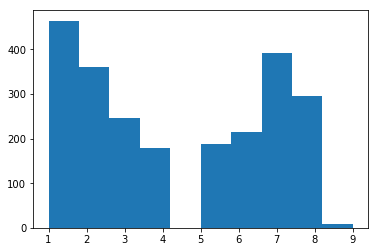

In [41]:
enrol_years = dict()

years = pd.DataFrame(enrol.groupby("CourseCodes").Year.unique())
years.reset_index(inplace = True)
years.CourseCodes = years.CourseCodes.apply(lambda x : x.split(";")[0])
years.Year = years.Year.apply(lambda x : len(x))
years.set_index("CourseCodes", inplace = True)
years = years.to_dict()['Year']

output = open(os.path.join("Graphs",'years.pkl'), 'wb')
# Pickle dictionary using protocol 0.
pickle.dump(years, output)
output.close()

plt.hist(list(years.values()))

## 2.5. Handling Cases Where Students Failed Courses And Followed Them Multiple Times
To avoid high weights due to courses which were taken multiple times by the same students we only kept the record of their first enrollement. 

In [42]:
print("Before removing duplicates : ", len(enrol))
enrol.drop_duplicates(subset = ["PersonID", "CourseCodes"], keep = "last", inplace = True)

print("After removing duplicates : ", len(enrol))

Before removing duplicates :  591209
After removing duplicates :  552030


## 2.6. Removing Irrelevant Courses

Here we removed all students following internships or in the CMS or first year as these are irrelevant to our application. We also removed courses that no longer exist as there is no point in recommending them


In [43]:
# Remove the internships 
enrol=enrol[~enrol['SubjectName'].str.contains("Stage|stage|Internship|internship")]
print(len(enrol))
# Remove the PDM and the useless years
enrol=enrol[~enrol['StudyPlanCode'].str.contains("BA1|BA2|BA3|BA4|PREPA1|PREPA2")]
enrol=enrol[~enrol['SubjectName'].str.contains("Projet|projet|Project|project")]

# Keep only the course that still exist:
valid_courses=courses.index.unique().tolist()
enrol=enrol[enrol['CourseCodes'].isin(valid_courses)]
# Do the same for the courses
courses=courses[courses.index.isin(enrol['CourseCodes'].unique())]

enrol.to_pickle("../data/cleanedAR_enrol_initial.pickle")
courses.to_pickle("../data/cleanedAR_courses_initial.pickle")

print(len(enrol))
# Remove the SHS:
enrol=enrol[~enrol['CourseSection'].str.contains("HUM")]
# Remove courses that only Architects take 
ARcourse = courses.index[courses.StudyPlans.str.contains('AR')].tolist()
SIEcourse = courses.index[courses.StudyPlans.str.contains('SIE')].tolist()
MEScourse = courses.index[courses.StudyPlans.str.contains('MES')].tolist()
GCcourse = courses.index[courses.StudyPlans.str.contains('^ ?GC| ?; ?GC')].tolist()
INcourse = courses.index[courses.StudyPlans.str.contains('^ ?IN| ?; ?IN|^ ?SC| ?; ?SC')].tolist()
SBcourse = courses.index[courses.StudyPlans.str.contains('^ ?SB| ?; ?SB')].tolist()
SVcourse =  courses.index[courses.StudyPlans.str.contains('^ ?SV| ?; ?SV')].tolist()
STIcourse = courses.index[courses.StudyPlans.str.contains('^ ?GM| ?; ?GM|^ ?MT| ?; ?MT|^ ?EL| ?; ?EL|^ ?MX| ?; ?MX')].tolist()
ARcourse=list(set(ARcourse)|set(SIEcourse)-set(INcourse)-set(SBcourse)-set(STIcourse)-set(SVcourse))
ARcourse.append('AR-461')

enrol=enrol[~enrol.CourseCodes.isin(ARcourse)]

print(len(enrol), len(courses))

549373
168514
140841 798


## 2.7 Attributes of the Final DataFrame

In [44]:
print(len(enrol))
for col in enrol.columns.tolist():
    print(col, len(enrol[col].unique()))

140841
PersonID 11607
SubjectID 912
Year 9
Semester 14
SubjectName 911
SectionName 54
StudentSectionCode 20
StudyPlanCode 6
CourseCodes 682
CourseSection 20
CourseID 263


# 3. Save the data

## 3.1 3rd Year and Master Courses For All Except AR

In [45]:
# Keep only the course that still exist:
valid_courses=courses.index.unique().tolist()
enrol=enrol[enrol['CourseCodes'].isin(valid_courses)]
# Do the same for the courses
courses=courses[courses.index.isin(enrol['CourseCodes'].unique())]

print(len(courses))

enrol.to_pickle("../data/cleaned_enrol.pickle")
courses.to_pickle("../data/cleaned_courses.pickle")

682


## 3.2 STI Master Courses

In [46]:
enrol = enrol[enrol.StudyPlanCode != 'BA5']
enrol = enrol[enrol.StudyPlanCode != 'BA6']

enrol_tmp = enrol.copy()
enrol = enrol_tmp[enrol_tmp.CourseSection == 'ME'] 
enrol = enrol.append(enrol_tmp[enrol_tmp.CourseSection == 'MICRO'], ignore_index=True)
enrol = enrol.append(enrol_tmp[enrol_tmp.CourseSection == 'EE'], ignore_index=True)
enrol = enrol.append(enrol_tmp[enrol_tmp.CourseSection == 'MSE'], ignore_index=True)
enrol = enrol.append(enrol_tmp[enrol_tmp.CourseSection == 'BIOENG'], ignore_index=True)

courses=courses[courses.index.isin(enrol['CourseCodes'].unique())]

print(len(courses))

enrol.to_pickle("../data/cleaned_enrol_STI.pickle")
courses.to_pickle("../data/cleaned_courses_STI.pickle")

196
